In [1]:
#from Utils import PklsFolder
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from scapy.all import *
import numpy as np

import os
import glob
import pickle
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
def has_file_allowed_extension(filename, extensions):
    return filename.lower().endswith(extensions)

def make_dataset(directory, class_to_idx, extensions='.pkl'):
    instances = []
    directory = os.path.expanduser(directory)
    def is_valid_file(x):
        return has_file_allowed_extension(x, extensions)
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    item = path, class_index
                    instances.append(item)
    return instances

class PklsFolder(Dataset):
    def __init__(self, root_dir):
        classes, class_to_idx = self._find_classes(root_dir)
        samples = make_dataset(root_dir, class_to_idx)
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort(key = lambda x : int(x))
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __getitem__(self, index):
        path, target = self.samples[index]
        with open(path, 'rb') as f:
            sample = pickle.load(f)
        """
        #flow = np.zeros([128, 1500])
        flow = np.zeros([80,350])
        #for i in range(len(sample)):
        #for i in range(min(128,len(sample))):
        for i in range(min(80,len(sample))):
            #flow[i, :len(sample[i])] = np.frombuffer(sample[i][:1500], dtype=np.uint8)
            flow[i, :len(sample[i])] = np.frombuffer(sample[i][:350], dtype=np.uint8)
            #randomize MAC,IP addresses
            flow[i, 0:12] = np.random.randint(256, size = 12, dtype = np.uint8)
            flow[i, 26:34] = np.random.randint(256, size = 8, dtype = np.uint8)
        
        if target > 0:
            target = 1
        """
        return sample, target

    def __len__(self):
        return len(self.samples)
    
    def data_cnt_per_class(self):
        class_cnt = {label : 0 for label in self.classes}
        for i in range(len(self.targets)):
            class_cnt[str(self.targets[i])] += 1
        return class_cnt

In [3]:
pkls_dir = '../../pkls'
flow_dataset = PklsFolder(pkls_dir)

In [4]:
null_list = np.load('./ISCX2012/ISCX2012_null_index.npy')

In [5]:
null_class_list = []

for i in null_list:
    flow, label = flow_dataset[i]
    null_class_list.append(label)

In [6]:
null_class = {}
for label, cnt in pd.Series(null_class_list).value_counts().items():
    null_class[label] = cnt

In [7]:
flow_cnt = flow_dataset.data_cnt_per_class()

for label, cnt in null_class.items() :
    flow_cnt[str(label)] -= cnt

mal_cnt = 0
for i in [2,3,4,6]:
    mal_cnt += flow_cnt[str(i)]

In [8]:
print(f'Benign flow count : {flow_cnt[str(0)]}')

Benign flow count : 2769358


In [9]:
print(f'Malicious flow count : {mal_cnt}')

Malicious flow count : 57847


In [10]:
flow_cnt

{'0': 2769358, '1': 2091, '2': 9920, '3': 2768, '4': 37303, '5': 12, '6': 7856}

In [11]:
flow_dataset.data_cnt_per_class()

{'0': 2913224,
 '1': 2091,
 '2': 10488,
 '3': 3209,
 '4': 37308,
 '5': 12,
 '6': 7864}

In [30]:
ben_5tup = {'Source IP' : [], 'Source Port' : [], 'Destination IP' : [], 'Destination Port' : [], 'Protocol' : []}
mal_5tup = {'Source IP' : [], 'Source Port' : [], 'Destination IP' : [], 'Destination Port' : [], 'Protocol' : []}


for i in tqdm(range(len(flow_dataset))):
    flow, label = flow_dataset[i]
    
    if i in null_list:
        continue
        
    elif label == 0:
        pck = Ether(flow[0])
        ben_5tup['Source IP'].append(pck['IP'].src)
        ben_5tup['Source Port'].append(pck.sport)
        ben_5tup['Destination IP'].append(pck['IP'].dst)
        ben_5tup['Destination Port'].append(pck.dport)
        ben_5tup['Protocol'].append(str(pck.layers()[2]).split('.')[-1][:3])
            
    elif label in [2,3,4,6]:
        pck = Ether(flow[0])
        mal_5tup['Source IP'].append(pck['IP'].src)
        mal_5tup['Source Port'].append(pck.sport)
        mal_5tup['Destination IP'].append(pck['IP'].dst)
        mal_5tup['Destination Port'].append(pck.dport)
        mal_5tup['Protocol'].append(str(pck.layers()[2]).split('.')[-1][:3])

100%|██████████| 2974196/2974196 [32:06<00:00, 1543.72it/s] 


In [31]:
five_tup = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol']

for field in five_tup:
    Benign = pd.Series(ben_5tup[field]).value_counts().head(5).reset_index()
    Benign = Benign.rename(columns = {'index' : field, 0 : 'Count'})
    Benign['Percentage'] = Benign['Count'].map(lambda x : round(100 * x / len(ben_5tup[field]),2))

    display(Benign)

,Source IP,Count,Percentage
0,192.168.5.122,411052,14.84
1,192.168.2.107,312492,11.28
2,192.168.4.118,195660,7.07
3,192.168.1.101,156966,5.67
4,192.168.2.109,146001,5.27


,Source Port,Count,Percentage
0,58040,77446,2.80
1,138,16740,0.60
2,137,14932,0.54
3,1027,2313,0.08
4,2580,2123,0.08


,Destination IP,Count,Percentage
0,198.164.30.2,365562,13.20
1,203.73.24.75,322815,11.66
2,125.6.164.51,191374,6.91
3,192.168.5.122,140838,5.09
4,202.210.143.140,69601,2.51


,Destination Port,Count,Percentage
0,80,2039089,73.63
1,53,451944,16.32
2,443,68739,2.48
3,138,16740,0.60
4,25,16215,0.59


,Protocol,Count,Percentage
0,TCP,2207309,79.7
1,UDP,562049,20.3


In [32]:
five_tup = ['Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol']

for field in five_tup:
    Mal = pd.Series(mal_5tup[field]).value_counts().head(5).reset_index()
    Mal = Mal.rename(columns = {'index' : field, 0 : 'Count'})
    Mal['Percentage'] = Mal['Count'].map(lambda x : round(100 * x / len(mal_5tup[field]),2))

    display(Mal)

,Source IP,Count,Percentage
0,192.168.1.105,12590,21.76
1,192.168.2.113,11411,19.73
2,192.168.2.110,8438,14.59
3,131.202.243.90,7843,13.56
4,192.168.4.118,5194,8.98


,Source Port,Count,Percentage
0,54806,7080,12.24
1,52707,1274,2.20
2,34431,1195,2.07
3,53508,703,1.22
4,6667,414,0.72


,Destination IP,Count,Percentage
0,192.168.5.122,46311,80.06
1,192.168.2.112,1179,2.04
2,192.168.2.113,1053,1.82
3,192.168.2.109,1038,1.79
4,192.168.2.110,1020,1.76


,Destination Port,Count,Percentage
0,80,38713,66.92
1,22,7958,13.76
2,443,229,0.40
3,445,168,0.29
4,143,103,0.18


,Protocol,Count,Percentage
0,TCP,57823,99.96
1,UDP,24,0.04


In [33]:
ben_flow_len = []
mal_flow_len = []
ben_pck_len = []
mal_pck_len = []

for i in tqdm(range(len(flow_dataset))):
    flow, label = flow_dataset[i]
    
    if i in null_list:
        continue
    
    elif label == 0:
        ben_flow_len.append(len(flow))
        
        for b_idx in range(len(flow)):
            ben_pck_len.append(len(flow[b_idx]))
    elif label != 0:
        mal_flow_len.append(len(flow))
        
        for m_idx in range(len(flow)):
            mal_pck_len.append(len(flow[m_idx]))

100%|██████████| 2974196/2974196 [05:09<00:00, 9609.34it/s] 


In [34]:
ben_over_128 = 0
for i in tqdm(range(len(ben_flow_len))):
    if ben_flow_len[i] > 128:
        ben_over_128 +=1

100%|██████████| 2769358/2769358 [00:01<00:00, 2130314.53it/s]


In [35]:
mal_over_128 = 0
for i in tqdm(range(len(mal_flow_len))):
    if mal_flow_len[i] > 128:
        mal_over_128 +=1

100%|██████████| 59950/59950 [00:00<00:00, 1589786.14it/s]


In [36]:
print(f'Percentage of Benign Flow Length Over 128: {100 *ben_over_128/len(ben_flow_len):.4f}%')

Percentage of Benign Flow Length Over 128: 0.0000%


In [37]:
print(f'Percentage of Malicious Flow Length Over 128: {100 *mal_over_128/len(mal_flow_len):.4f}%')

Percentage of Malicious Flow Length Over 128: 0.0000%


In [38]:
print(f'Average of Benign Flow Length : {pd.DataFrame(ben_flow_len).mean()}')

Average of Benign Flow Length : 0    9.13744
dtype: float64


In [39]:
print(f'Average of Malicious Flow Length : {pd.DataFrame(mal_flow_len).mean()}')

Average of Malicious Flow Length : 0    52.604887
dtype: float64


Text(0, 0.5, 'Density')

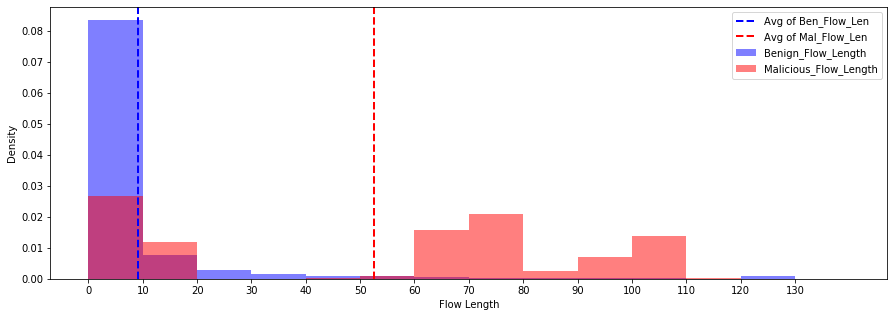

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))

plt.hist(ben_flow_len, bins = 14, alpha = 0.5, range = (0,140), density = True, color = 'b', label = 'Benign_Flow_Length')
plt.hist(mal_flow_len, bins = 14, alpha = 0.5, range = (0,140), density = True, color = 'r', label = 'Malicious_Flow_Length')
plt.xticks(np.arange(0,140,10))

plt.axvline(pd.DataFrame(ben_flow_len).mean().item(), color='b', linestyle='dashed', linewidth=2, label = 'Avg of Ben_Flow_Len')
plt.axvline(pd.DataFrame(mal_flow_len).mean().item(), color='r', linestyle='dashed', linewidth=2, label = 'Avg of Mal_Flow_Len')

plt.legend()
plt.xlabel('Flow Length')
plt.ylabel('Density')

In [41]:
ben_over_1000 = 0
for i in tqdm(range(len(ben_pck_len))):
    if ben_pck_len[i] > 1000:
        ben_over_1000 +=1

100%|██████████| 25304842/25304842 [00:10<00:00, 2388475.37it/s]


In [42]:
mal_over_1000 = 0
for i in tqdm(range(len(mal_pck_len))):
    if mal_pck_len[i] > 1000:
        mal_over_1000 +=1

100%|██████████| 3153663/3153663 [00:01<00:00, 2138620.86it/s]


In [43]:
print(f'Percentage of Benign Packet Length Over 1000: {100 *ben_over_1000/len(ben_pck_len):.4f}%')

Percentage of Benign Packet Length Over 1000: 0.1465%


In [44]:
print(f'Percentage of Malicious Packet Length Over 1000: {100 *mal_over_1000/len(mal_pck_len):.4f}%')

Percentage of Malicious Packet Length Over 1000: 0.1125%


In [45]:
print(f'Average of Benign Packet Length : {pd.DataFrame(ben_pck_len).mean()}')

Average of Benign Packet Length : 0    78.064581
dtype: float64


In [46]:
print(f'Average of Malicious Packet Length : {pd.DataFrame(mal_pck_len).mean()}')

Average of Malicious Packet Length : 0    105.42022
dtype: float64


Text(0, 0.5, 'Density')

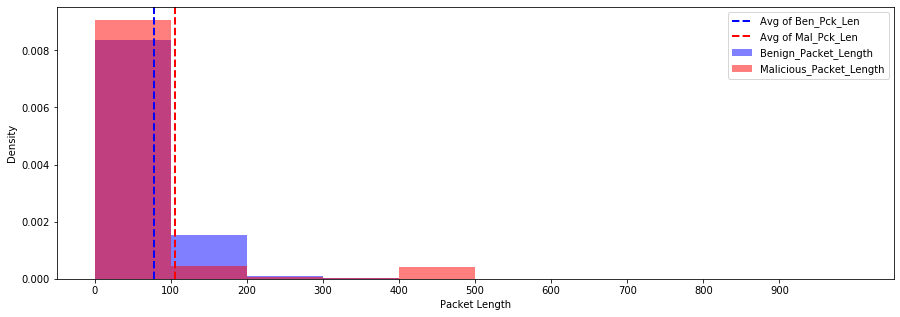

In [47]:
plt.figure(figsize = (15,5))

plt.hist(ben_pck_len, bins = 10, alpha = 0.5, range = (0,1000), density = True, color = 'b', label = 'Benign_Packet_Length')
plt.hist(mal_pck_len, bins = 10, alpha = 0.5, range = (0,1000), density = True, color = 'r', label = 'Malicious_Packet_Length')
plt.xticks(np.arange(0,1000,100))

plt.axvline(pd.DataFrame(ben_pck_len).mean().item(), color='b', linestyle='dashed', linewidth=2, label = 'Avg of Ben_Pck_Len')
plt.axvline(pd.DataFrame(mal_pck_len).mean().item(), color='r', linestyle='dashed', linewidth=2, label = 'Avg of Mal_Pck_Len')

plt.legend()

plt.xlabel('Packet Length')
plt.ylabel('Density')